<a href="https://colab.research.google.com/github/lehai-ml/Workshop_AI/blob/master/Machine_Learning_Workshop_2_Image_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Workshop 2: Image Style Transfer
*Instructor:* Le Hai, (le.hai@kcl.ac.uk)
[KCL Artificial Intelligence Society](https://www.facebook.com/kclaisoc/?__xts__[0]=68.ARBS16FGqFmhg52L83VtU55PY45QGKlU8Jrej-r7ZHALKkj9E4dzZMvGfDvg8oHnazPAlEJQ80M7--6XTHbh6hyvOoplBMVsWLITGjI5PEc8xf-ap7n00ASBE92fNKalpTFcK2OlA0hVimQEDNWEmrQkWmIQ_UiAqxDR9CQuD8YMZNBUIVOpnatRb-AKTJy5xAwKYyBa7kaBUHVsgqoCqx6BUHqgg6_0wQUoRKvWAak1mE5Vdq4uGSPpTcFtaUJz4z1iHQUaUYUjpYcMDtmuu6LFRiMnXkZaQa4YEguXNsCSBmw2tAeMX3gOXMPke-mSHO6FxwFE7Mymu0zkHZu67Mo&eid=ARB2iiXncCNlQsYa-y6uPQ7o0e_PN2CjhwNmnyTVAgy9emKkNf0k27tbD1PgM2vK_zkbN5DoiGECvZ82)

**This workshop was taken and modified from:** https://towardsdatascience.com/style-transfer-styling-images-with-convolutional-neural-networks-7d215b58f461


The [original paper](https://arxiv.org/abs/1508.06576) on Image style transfer is quite an easy read, so make sure to check it out as well!

The idea of **Image style transfer** is to combine **content** of one image with a **style** from another (check this website out: ["turn your photos into arts"](https://deepart.io )). In order to do this you need to understand how to extract "content" and "style" information from your Convolutional neural network model.

AS ALWAYS MAKE SURE YOU TURN ON GPU OPTION IN THIS NOTEBOOK! (Edit/Notebook Settings/)

## Extracting content from an image:

CNN is consisted of a number of layers, that process visual infromation in a hiearchical and feed-forward manner. In each one of these layers are number of filters, that extract certain features from the input image; in other words, you can see what each layer has "learnt" by combining all the filters from that layer (feature maps)

Because the information flows in one direction in CNN, the input image is transformed into representation that increasingly care about the actual content of the image compared to its detailed pixel value. So in lower level, the feature map will be almost exact replication of the input image, detailed pixel by pixel, but in the higher level, the feature map will be more about the global arrangement of the content.


## Extracting style from an image

To extract the style of an input image, we use feature space originally designed to capture texture information. Think of the feature space as a function that capture how similar different filters are within and between layers. If a certain pattern is important, i.e. the texture of the painting, then it must be repeated in many of the filters within **and** between layers. Therefore, we just need to derive this feature space and we can get the style.

![](https://cuicaihao.files.wordpress.com/2017/06/11.png)

taken directly from Gatys et al., 2015

Now we know how to extract the content and style of the image, then we want our combined image to be as similar to our content image (content loss), to our style image (style loss), and as little noise as possible (total variation loss).


For this exercise we will use **Transfer learning**, a concept where we use an already pretrained model, in this case VGG16, and modify it for our purposes.

## Data Preprocessing and Normalization:

One important thing about Transfer learning is that you need to modify your own data to make it acceptable by your model. In this case, VGG16 requires input images to be in a tensor of (n,500,500,3) and in BGR instead of RGB.

In [ ]:
# Import necessary libraries
import numpy as np
from PIL import Image
import requests
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16#the pretrained model

from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [ ]:
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

Go to Google Image, find image that you want, right click on the image and choose Copy image address. Then paste that address on the image path.

In [ ]:
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"

# San Francisco
san_francisco_image_path = "https://www.economist.com/sites/default/files/images/print-edition/20180602_USP001_0.jpg"

# Warsaw by Tytus Brzozowski, http://t-b.pl
tytus_image_path = "http://meetingbenches.com/wp-content/flagallery/tytus-brzozowski-polish-architect-and-watercolorist-a-fairy-tale-in-warsaw/tytus_brzozowski_13.jpg"
#starry night: 'https://images.saatchiart.com/saatchi/835662/art/5412781/4482593-BSWQLRZU-7.jpg'
#golconda: 'https://www.renemagritte.org/images/paintings/golconda.jpg'
#three muscians:'https://www.pablopicasso.org/images/paintings/three-musicians.jpg'
#La goule: 'https://www.metmuseum.org/toah/images/hb/hb_32.88.12.jpg'

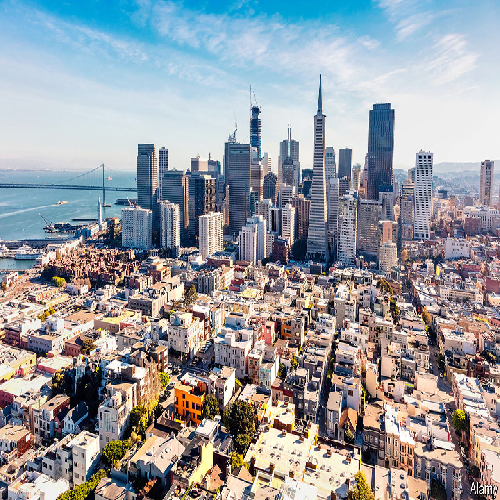

In [ ]:
#Input visualization 
input_image = Image.open(BytesIO(requests.get(san_francisco_image_path).content))
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image.save(input_image_path)
input_image

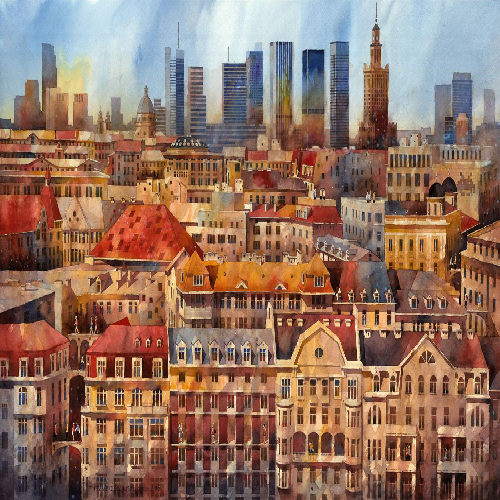

In [ ]:
# Style visualization 
style_image = Image.open(BytesIO(requests.get(tytus_image_path).content))
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

In [ ]:
# Data normalization and reshaping from RGB to BGR
input_image_array = np.asarray(input_image, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

## Initializing the model on Tensorflow, and defining our optimization problem

In [ ]:
# Model
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)

### Content loss

This is the squared distance between the output image and the content image.

The layer that you are extracting the "content" information is block2_conv2 from VGG16 network.

In [ ]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block2_conv2'
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * content_loss(content_image_features,
                                      combination_features)

### Style loss:

This is  sum of the dot product between the filters in the style layers.

The layers that you are extracting the "style" information are block1_conv2,block2_conv2,block3_conv3,block4_conv3,block5_conv3. You could of course use any layers you want. If you have time play around and see for yourself. Just make sure the image dimensions are correct.

In [ ]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))#shape=(512,31x31)
    gram = backend.dot(features, backend.transpose(features))#final dimension=(512,512)
    return gram

In [ ]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (STYLE_WEIGHT / len(style_layers)) * style_loss

## Total Variation Loss:

This is just to minimize the noise, because you are using both content and style loss, you need this to smoothen the final product.

In [ ]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

Combining everything together and defining your evaluator, and specify that it will be run on L_Bfgs algorithm.

In [ ]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Iteration 0 completed with loss 103656382464
Iteration 1 completed with loss 41805045760
Iteration 2 completed with loss 28646948864
Iteration 3 completed with loss 24748560384
Iteration 4 completed with loss 23002824704
Iteration 5 completed with loss 22186086400
Iteration 6 completed with loss 21690286080
Iteration 7 completed with loss 21396905984
Iteration 8 completed with loss 21199769600
Iteration 9 completed with loss 21039034368


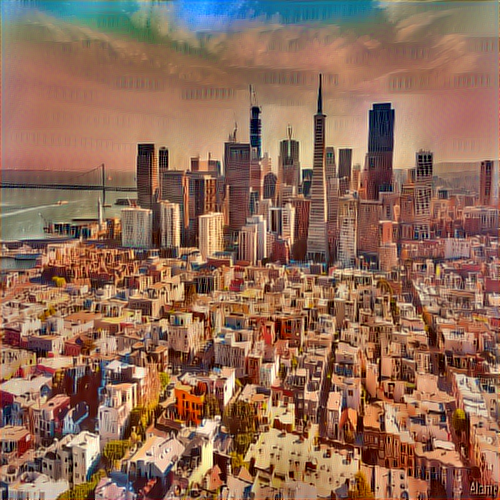

In [ ]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

In [ ]:
# Visualizing combined results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [input_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save(combined_image_path)
combined